# Quant GAN
## Torch Verison
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from preprocess.acf import *
from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.torch_tcn import *

from utils.data_parser import parse_yahoo_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


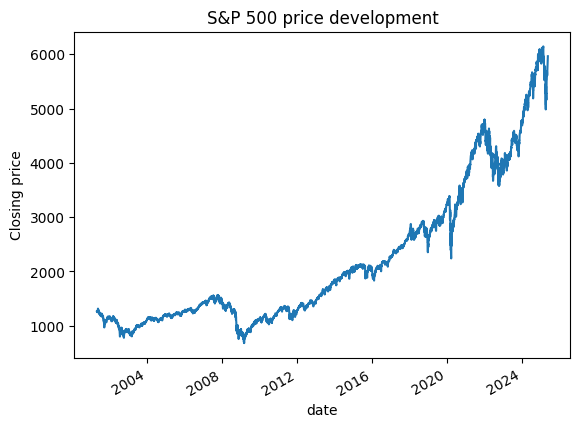

In [2]:
df = yf.download("^GSPC", start="2001-05-01", end="2025-05-20")
df = parse_yahoo_data(df)
# df = yf.download("^GSPC", start="2024-01-05", end="2024-03-01", interval='2m')

df = df.close
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

df.plot(ylabel='Closing price', title='S&P 500 price development');

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [3]:
class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
data_size = log_returns.shape[0]
print(log_returns_preprocessed.shape)
print(data_size)

(6048, 1)
6048


## Train model
 For more details see [torch_model.ipynb](./torch_model.ipynb)

In [4]:
num_epochs = 15
nz = 3
batch_size = 64 
seq_len = 127
clip= 0.01

generator_path = f'./trained/'
file_name = 'SP500_daily'

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [5]:

train = False
generator = Generator().to(device)

if train:
    dataset = Loader32(log_returns_preprocessed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    discriminator = Discriminator(seq_len).to(device)
    gan = GAN(generator, discriminator)
    gan.train(dataloader, nz, num_epochs, clip, device, generator_path)
    # Save
else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_epoch_{num_epochs-1}.pth', weights_only=False)
    generator.eval()

## Generate

In [6]:
generator.eval()
noise = torch.randn(100,3,2537).to(device)

y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

96

In [7]:
from utils.data_parser import returns_to_csv
returns_to_csv(y)

Saving DCSYN_0000.csv
Saving DCSYN_0001.csv
Saving DCSYN_0002.csv
Saving DCSYN_0003.csv
Saving DCSYN_0004.csv
Saving DCSYN_0005.csv
Saving DCSYN_0006.csv
Saving DCSYN_0007.csv
Saving DCSYN_0008.csv
Saving DCSYN_0009.csv
Saving DCSYN_0010.csv
Saving DCSYN_0011.csv
Saving DCSYN_0012.csv
Saving DCSYN_0013.csv
Saving DCSYN_0014.csv
Saving DCSYN_0015.csv
Saving DCSYN_0016.csv
Saving DCSYN_0017.csv
Saving DCSYN_0018.csv
Saving DCSYN_0019.csv
Saving DCSYN_0020.csv
Saving DCSYN_0021.csv
Saving DCSYN_0022.csv
Saving DCSYN_0023.csv
Saving DCSYN_0024.csv
Saving DCSYN_0025.csv
Saving DCSYN_0026.csv
Saving DCSYN_0027.csv
Saving DCSYN_0028.csv
Saving DCSYN_0029.csv
Saving DCSYN_0030.csv
Saving DCSYN_0031.csv
Saving DCSYN_0032.csv
Saving DCSYN_0033.csv
Saving DCSYN_0034.csv
Saving DCSYN_0035.csv
Saving DCSYN_0036.csv
Saving DCSYN_0037.csv
Saving DCSYN_0038.csv
Saving DCSYN_0039.csv
Saving DCSYN_0040.csv
Saving DCSYN_0041.csv
Saving DCSYN_0042.csv
Saving DCSYN_0043.csv
Saving DCSYN_0044.csv
Saving DCS

## Results and visualizing stylized facts

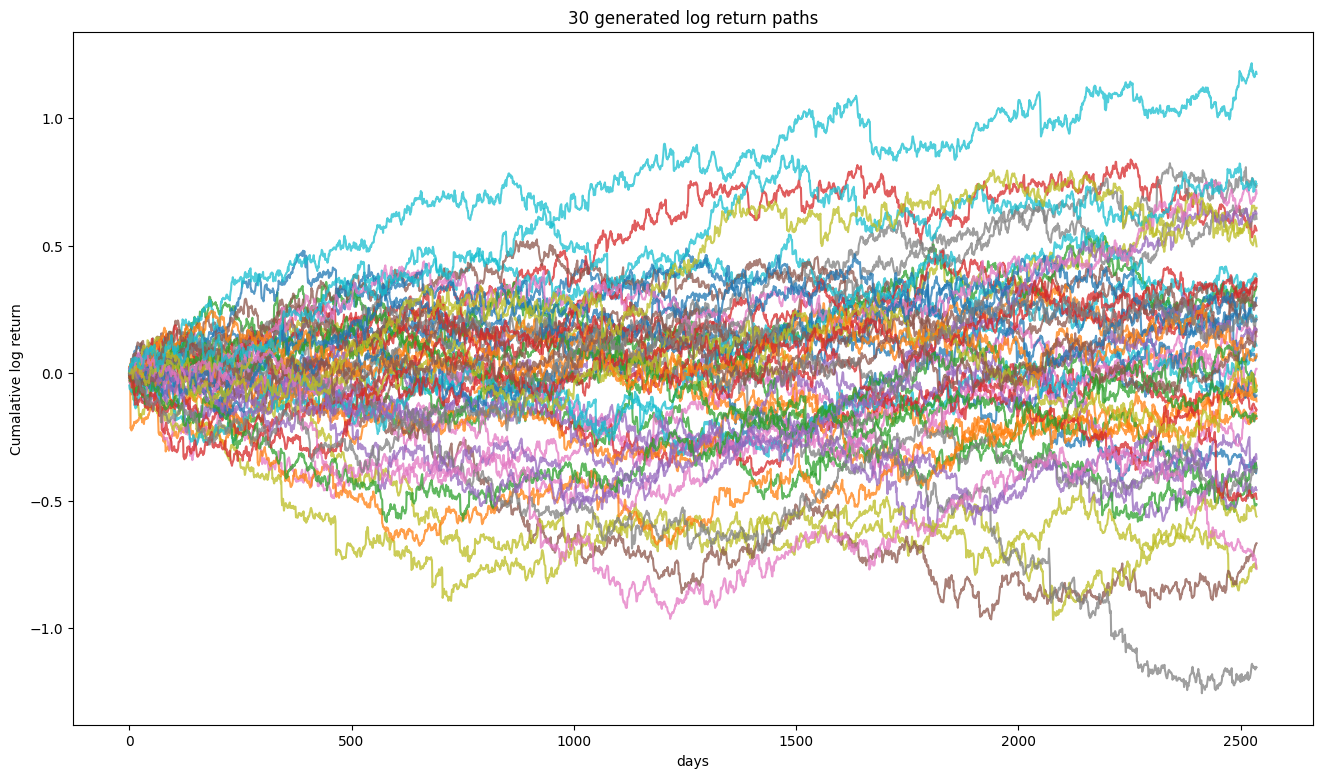

In [12]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:50], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

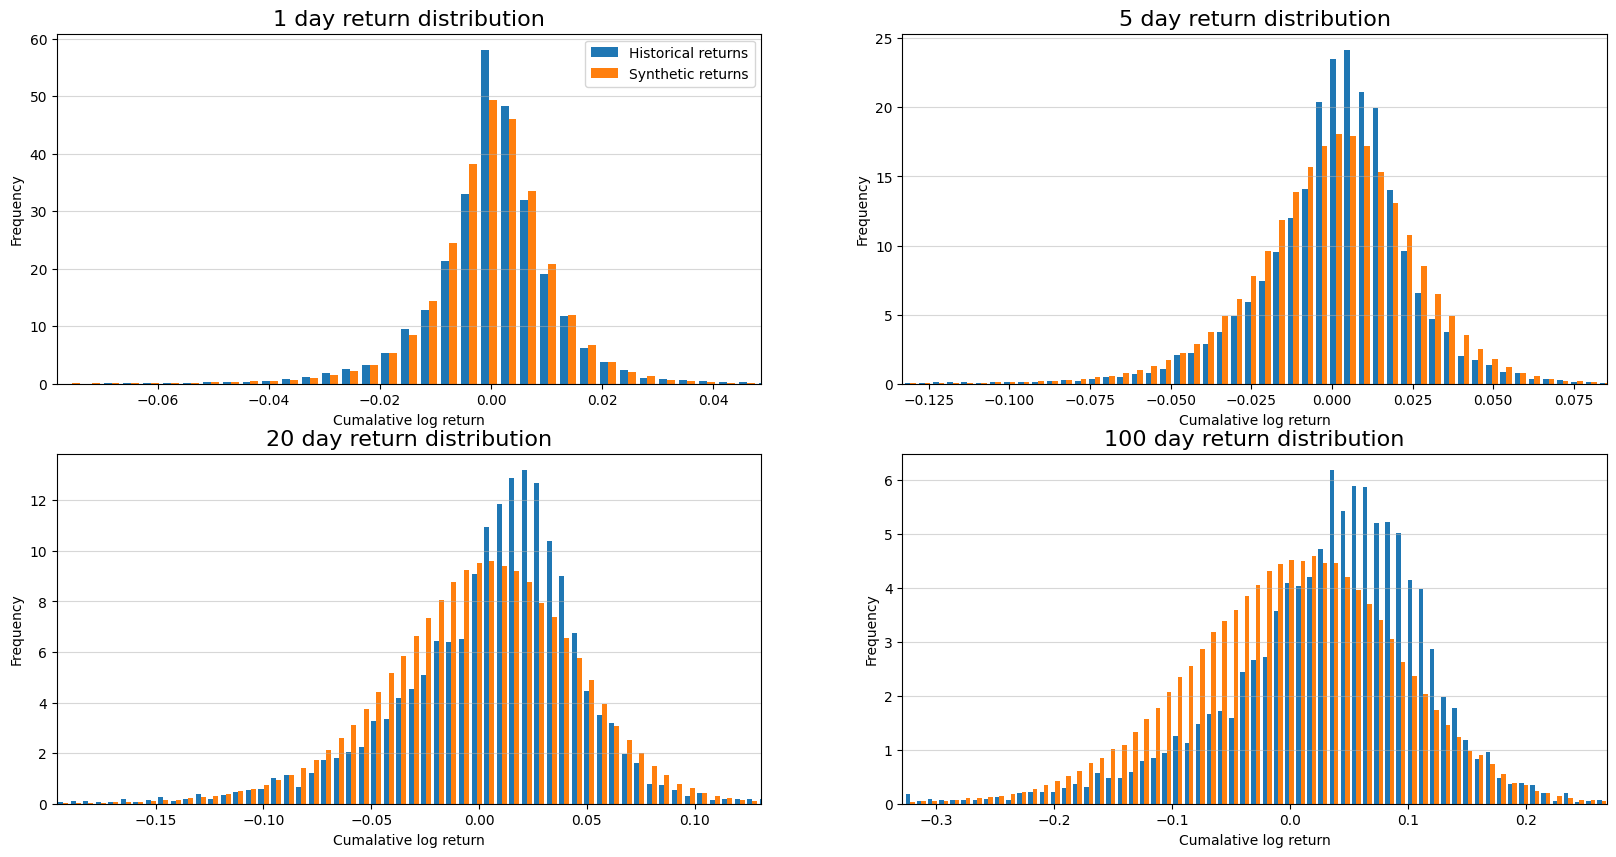

In [11]:
n_bins = 100
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=n_bins, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days)'),
 Text(0.5, 0, 'Lag (number of days)'),
 Text(0.5, 0, 'Lag (number of days)'),
 Text(0.5, 0, 'Lag (number of days)')]

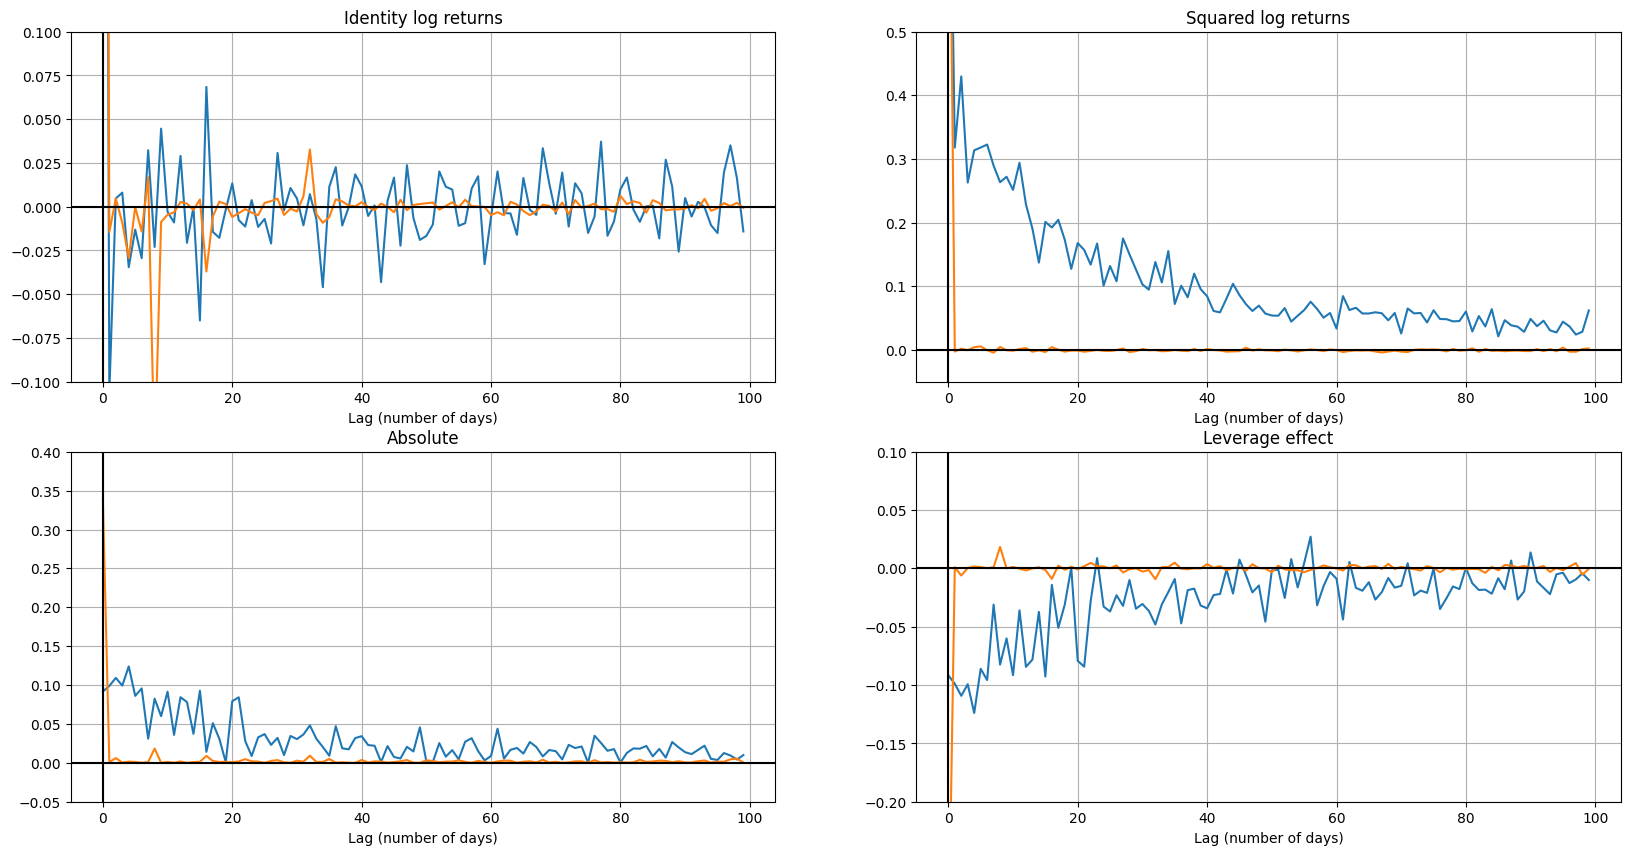

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

lag = 100
axs[0,0].plot(acf(log_returns, lag))
axs[0,0].plot(acf(y.T, lag).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, lag))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, lag).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, lag, le=True)))
axs[1,0].plot(abs(acf(y.T, lag, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, lag, le=True))
axs[1,1].plot(acf(y.T, lag, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days)')